In [11]:
import torch
from torch import nn, optim
from torch.utils.data import (Dataset, DataLoader, TensorDataset)
import tqdm

from torchvision.datasets import ImageFolder
from torchvision import transforms


from torchvision.utils import save_image

In [12]:
img_data = ImageFolder("oxford-102/",
    transform=transforms.Compose([
        transforms.Resize(80),
        transforms.CenterCrop(64),
        transforms.ToTensor()
]))

batch_size = 64
img_loader = DataLoader(img_data, batch_size=batch_size,
                        shuffle=True)

In [13]:
nz = 100
ngf = 32
class GNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 
                               4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 2, ngf,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf, 3,
                               4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [14]:
ndf = 32

class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )
    
    def forward(self, x):
        out = self.main(x)
        return out.squeeze()

In [15]:
d = DNet().to("cuda:0")
g = GNet().to("cuda:0")

# Adam의 파라미터는 원 논문에서 제안하는 값
opt_d = optim.Adam(d.parameters(),
    lr=0.0002, betas=(0.5, 0.999))
opt_g = optim.Adam(g.parameters(),
    lr=0.0002, betas=(0.5, 0.999))

# 크로스 엔트로피를 계산하기 위한 보조 변수 등
ones = torch.ones(batch_size).to("cuda:0")
zeros = torch.zeros(batch_size).to("cuda:0")
loss_f = nn.BCEWithLogitsLoss()

# 모니터링용 z
fixed_z = torch.randn(batch_size, nz, 1, 1).to("cuda:0")

In [16]:
from statistics import mean

def train_dcgan(g, d, opt_g, opt_d, loader):
    # 생성 모델, 식별 모델의 목적 함수 추적용 배열
    log_loss_g = []
    log_loss_d = []
    for real_img, _ in tqdm.tqdm(loader):
        batch_len = len(real_img)
        
        # 실제 이미지를 GPU로 복사
        real_img = real_img.to("cuda:0")
        
        # 가짜 이미지를 난수와 생성 모델을 사용해 만든다
        z = torch.randn(batch_len, nz, 1, 1).to("cuda:0")
        fake_img = g(z)
        
        # 나중에 사용하기 위해서 가짜 아미지의 값만 별도로 저장해둠
        fake_img_tensor = fake_img.detach()
        
        # 가짜 이미지에 대한 생성 모델의 평가 함수 계산
        out = d(fake_img)
        loss_g = loss_f(out, ones[: batch_len])
        log_loss_g.append(loss_g.item())

        # 계산 그래프가 생성 모델과 식별 모델 양쪽에
        # 의존하므로 양쪽 모두 경사하강을 끝낸 후에
        # 미분 계산과 파라미터 갱신을 실시
        d.zero_grad(), g.zero_grad()
        loss_g.backward()
        opt_g.step()
        
        #실제 이미지에 대한 식별 모델의 평가 함수 계산
        real_out = d(real_img)
        loss_d_real = loss_f(real_out, ones[: batch_len])
        
        # PyTorch에선 동일 Tensor를 포함한 계산 그래프에
        # 2회 backward를 할 수 없으므로 저장된 Tensor를
        # 사용해서 불필요한 계산은 생략
        fake_img = fake_img_tensor
        
        # 가짜 아미지에 대한 식별 모델의 평가 함수 계산
        fake_out = d(fake_img_tensor)
        loss_d_fake = loss_f(fake_out, zeros[: batch_len])
        
        # 진위 평가 함수의 합계
        loss_d = loss_d_real + loss_d_fake
        log_loss_d.append(loss_d.item())
        
        # 식별 모델의 미분 계산고 파라미터 갱신
        d.zero_grad(), g.zero_grad()
        loss_d.backward()
        opt_d.step()
                                             
    return mean(log_loss_g), mean(log_loss_d)

In [17]:
for epoch in range(300):
    train_dcgan(g, d, opt_g, opt_d, img_loader)
    # 10회 반복마다 학습 결과를 저장
    if epoch % 10 == 0:
        # 파라미터 저장
        torch.save(
            g.state_dict(),
            "g_{:03d}.prm".format(epoch),
            pickle_protocol=4)
        torch.save(
            d.state_dict(),
            "d_{:03d}.prm".format(epoch),
            pickle_protocol=4)
        # 모니터링용 z로부터 생성한 이미지 저장
        generated_img = g(fixed_z)
        save_image(generated_img,
                   "{:03d}.jpg".format(epoch))

 19%|█▉        | 24/128 [00:07<00:33,  3.12it/s]


KeyboardInterrupt: 

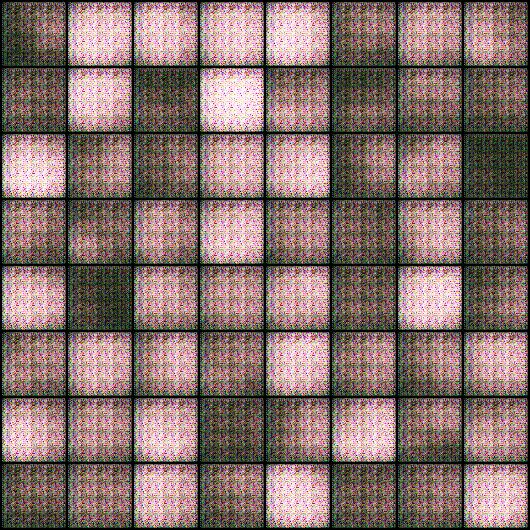

In [19]:
from IPython.display import Image,display_jpeg
display_jpeg(Image('000.jpg'))